In [2]:
%matplotlib inline
# 数据处理
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from gmplot import gmplot
from pykalman import KalmanFilter
# Enable inline plotting

names = ['lat','lng','zero','alt','days','date','time']  # CSV的属性名
streams_work = []
streams_weekends = []
TimeStamp = []
index = 0 # 作为分类后的数组中的循环下标
iter = 5 # 卡尔曼滤波的迭代次数
userdata = 'data\\Geolife Trajectories 1.3\\Data\\' + '001' + '\\Trajectory\\'
filelist = os.listdir(userdata)
#  卡尔曼滤波， 轨迹的平滑处理
def func_kalman_2(array):
    measurements = array

    initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]
# 变化矩阵， 除对角线外的数值数值类似 速度，越小使得轨迹更加平滑，减少GPS漂移， 需保持2个数值大小一致
    transition_matrix = [[1, 8, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 8],
                         [0, 0, 0, 1]]

    observation_matrix = [[1 ,0, 0, 0],
                          [0, 0, 1, 0]]

    kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)
    kf1 = kf1.em(measurements, n_iter=iter)
    (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)
    kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 20*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

    kf2 = kf2.em(measurements, n_iter=iter)
    (smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)
    return smoothed_state_means

for f in tqdm(filelist):
    # 读取数据
    df_list = [pd.read_csv(userdata + f,header=6,names=names,index_col=False, parse_dates=[['date', 'time']])]
    df = pd.concat(df_list, ignore_index=True)
    df.drop(['zero','alt','days'], axis=1, inplace=True)
    df.set_index('date_time')
    df_min = df.iloc[::12, :]    # 以1min的时间间隔去取值
    # 将字符串格式的时间转换为时间戳形式 ( float )
    time_h = df_min['date_time'].apply(lambda x:time.mktime(x.timetuple()))
    # 卡尔曼滤波器
    smooth = func_kalman_2(np.c_[df_min['lat'].values, df_min['lng'].values])
    # 数据整合 [ GPS 坐标， 时间戳 ]  float,float,float
    lat_lng_data = np.c_[smooth[:,0], smooth[:,2], time_h]
    # 分为工作日和周末
    if df_min['date_time'].dt.dayofweek.mode().values[0] < 5:
        streams_work.append(lat_lng_data)
    else:
        streams_weekends.append(lat_lng_data)

print(streams_work[0][0,0], streams_work[0][0,1], streams_work[0][0,2])


100%|██████████| 71/71 [00:49<00:00,  1.43it/s]


39.98424130785284 116.3193147947094 1224712386.0


In [ ]:
# 分类 1 - 节假日
import geopy.distance
from dipy.segment.metric import Metric
from dipy.segment.metric import ResampleFeature
import numpy as np
from dipy.segment.clustering import QuickBundles

STREAMS = streams_weekends

THRESHOLD = 1

class GPSDistance(Metric):
    def __init__(self):
        super(GPSDistance, self).__init__(feature=ResampleFeature(nb_points=300))  # 最终的轨迹质心长度
    # 同等长度的轨迹才进行比较分类
    def are_compatible(self, shape1, shape2):
        return len(shape1) == len(shape2)
    # 定义轨迹间的距离计算方式
    def dist(self, v1, v2):
        x = [geopy.distance.distance([p[0][0], p[0][1]], [p[1][0], p[1][1]]).kilometers  for p in list(zip(v1, v2)) if p[0][2] - p[1][2] < 10] # 二者时间戳相差少于10才进行比较
        currD = np.mean(x)
        return currD

metric = GPSDistance()
qb = QuickBundles(threshold=THRESHOLD, metric=metric)
print (time.strftime('%H:%M:%S',time.localtime(time.time())))
clusters = qb.cluster(STREAMS)
print (time.strftime('%H:%M:%S',time.localtime(time.time())))
print("Nb. clusters:", len(clusters))

In [3]:
# 分类 - 2
# 调整 threshold 去除仅含1条轨迹的类别
# 双 聚类 代码
import geopy.distance
from dipy.segment.clustering import QuickBundles

from dipy.segment.metric import Metric
from dipy.segment.metric import ResampleFeature
from tqdm import tqdm

STREAMS = streams_work

Min_Trajectory_Number = 1 # 定义轨迹类可包含的最小轨迹数目（ 即轨迹数目至少为2 ）

# 第一次聚类（低threshold 聚多类, 除去离群轨迹)
THRESHOLD_1 = 0.7

class GPSDistance(Metric):
    def __init__(self):
        super(GPSDistance, self).__init__(feature=ResampleFeature(nb_points=300))

    def are_compatible(self, shape1, shape2):
        return len(shape1) == len(shape2)

    def dist(self, v1, v2):
        x = [geopy.distance.distance([p[0][0], p[0][1]], [p[1][0], p[1][1]]).kilometers  for p in list(zip(v1, v2)) if p[0][2] - p[1][2] < 10]
        currD = np.mean(x)
        return currD

metric = GPSDistance()
qb = QuickBundles(threshold=THRESHOLD_1, metric=metric)

clusters = qb.cluster(STREAMS)
print("First Nb. clusters:", len(clusters))

# 去除离群轨迹
Keep_streams = []
mask = clusters > Min_Trajectory_Number
for index in tqdm(range(len(clusters))):
    if mask[index]:
        for i in clusters[index].indices:
            Keep_streams.append(STREAMS[i])


THRESHOLD_2 = 1.3
qb = QuickBundles(threshold=THRESHOLD_2, metric=metric)

clusters_2 = qb.cluster(Keep_streams)
print("Second Nb. clusters:", len(clusters_2))



100%|██████████| 15/15 [00:00<00:00, 15029.76it/s]
E:\Anaconda\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


First Nb. clusters: 15
Second Nb. clusters: 7


In [ ]:
# 画图 -- 1
from gmplot import gmplot
import random

CLUSTER = clusters

def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

gmap = gmplot.GoogleMapPlotter(streams_work[0][0,0], streams_work[0][0,1], 12) # 确立展示的地图中心

for clustersIndex in range(len(CLUSTER)):
    color = randomcolor()
    for i in CLUSTER[clustersIndex].indices:
        gmap.plot(streams_work[i][:,0], streams_work[i][:,1], color, edge_width=1) # 将点标注在地图上

gmap.draw("user001_map.html")
print('Map done')

In [4]:
# 距离矩阵计算函数
from datetime import datetime
from tqdm import tqdm

distance_list = []
time_list = []
# 改变质心的时间，使其分布均匀
def center_change_time_type(centroids):

    Test_Array = centroids

    dt1 = pd.date_range(start='2020-01-01',end='2020-01-02',freq="4.8T") # 300个点，与上文的Resample一致, 日期随意，因为不会用到
    pydate_array = dt1.to_pydatetime()
    pydate_array = np.delete(pydate_array,-1)
    Test_Array = np.delete(Test_Array, -1, axis=1)
    Test_Array = np.c_[Test_Array, pydate_array]

    return Test_Array
# 改变轨迹的时间类型
def stream_change_time_type(stream):

    temp_var = np.vectorize(lambda s: datetime.fromtimestamp(time.mktime(time.localtime(s))))(stream[:,2])
    temp_array = np.delete(stream, -1, axis=1)
    stream = np.c_[temp_array, temp_var]

    return stream
# 轨迹与质心对齐
def find_nearest_time_point(centroids, stream):

    index_of_point = np.argmin(np.vectorize(lambda t, s: (t-s).seconds)(center_change_time_type(centroids)[:,2], stream_change_time_type(stream)[0,2]))

    if centroids.shape[0] - index_of_point >= stream.shape[0]:
        is_longer_than_stream = True
    else:
        is_longer_than_stream = False

    return index_of_point, is_longer_than_stream

for i in tqdm(clusters_2[3].indices):

    index_of_point , is_longer_than_stream = find_nearest_time_point(clusters_2.centroids[3], streams_work[i])

    v1 = clusters_2.centroids[3][index_of_point:,:]

    if is_longer_than_stream:
        v2 = streams_work[i]
    else:
        v2 = streams_work[i][:v1.shape[0],:]
    '''
    |----<index>------------|  centroids
            |  v1.shape[0]  |
            v               v
           |0---------------end---------| streams
    '''
    x = [geopy.distance.distance([p[0][0], p[0][1]], [p[1][0], p[1][1]]).kilometers for p in list(zip(v1, v2))]
    # x = np.c_[x,v2[:,2]]
    distance_list = distance_list + x
    time_list = time_list + np.vectorize(lambda x:time.strftime('%H:%M:%S',time.localtime(x)))(v2[:,2]).tolist()

print(len(distance_list), len(time_list))

100%|██████████| 16/16 [00:00<00:00, 72.26it/s]


850 850


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                   ds      yhat  yhat_lower  yhat_upper
0 2020-08-28 04:24:55  4.390044    3.232559    5.554675
1 2020-08-28 04:25:30  4.386657    3.105928    5.544225
2 2020-08-28 04:26:13  4.382496    3.124653    5.568620
3 2020-08-28 04:26:50  4.378915    3.192031    5.586038
4 2020-08-28 04:27:47  4.373400    3.160594    5.582396


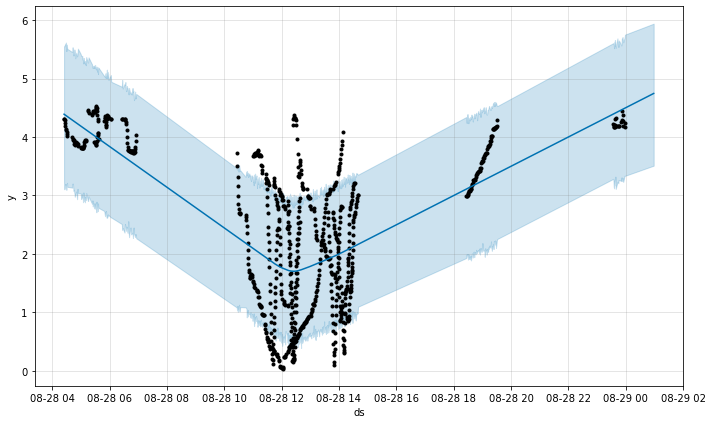

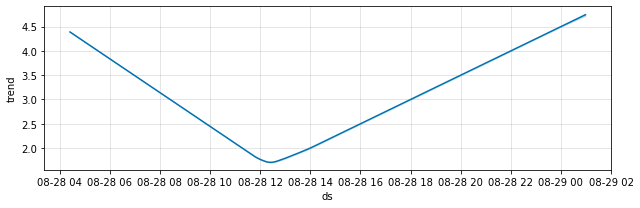

In [5]:
import pandas as pd
from fbprophet import Prophet
# df = pd.read_csv('data\example_wp_log_peyton_manning.csv')
# df.head()

# ds 列为时间 YYYY-mm-dd HH:MM: 形式
mm=pd.DataFrame(time_list,columns=['ds'])
mm=pd.concat([mm,pd.DataFrame(distance_list,columns=['y'])],axis=1)

x = mm['y']
y = mm['ds']
df = mm
m = Prophet()
m.fit(df)
# 预测未来1天，频率为1小时
future = m.make_future_dataframe(periods=1, freq='H')
fcst = m.predict(future)
print(fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# 画图
fig = m.plot(fcst)
fig = m.plot_components(fcst)

In [6]:
Test_Array = center_change_time_type(clusters_2.centroids[3])

Test_Point = np.array([Test_Array[0,0] + 5, Test_Array[0,1] + 10, Test_Array[0,2]])

index_test = np.argmin(np.vectorize(lambda t, s: (t-s).seconds)(Test_Array[:,2], Test_Point[2]))

distance_test = geopy.distance.distance([Test_Array[index,0],Test_Array[index,1]], [Test_Point[0],Test_Point[1]]).kilometers

fcst.dtypes
#
# time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(Test_Point[2]))

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
trend_upper                          float64
additive_terms                       float64
additive_terms_lower                 float64
additive_terms_upper                 float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
dtype: object

In [7]:
print(fcst.dtypes)
print(type(Test_Point[2]))
Test_Point[2] = Test_Point[2].replace(year = 2020, month = 8, day = 29)
print(Test_Point[2])

np.argmin(np.vectorize(lambda t, s: (t-s).seconds)(Test_Array[:,2], Test_Point[2]))

type(fcst.ds)

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
trend_upper                          float64
additive_terms                       float64
additive_terms_lower                 float64
additive_terms_upper                 float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
dtype: object
<class 'datetime.datetime'>
2020-08-29 00:00:00


pandas.core.series.Series